<a href="https://colab.research.google.com/github/DonaldTurton/AT2_Advanced_Data_Algorithms/blob/master/XGB_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# XGB

In [0]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt #Data Visualization
import seaborn as sns #Correlation plot
from google.colab import files

# Libraries for XGBOOST
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer

In [151]:
url = 'https://raw.githubusercontent.com/DonaldTurton/AT2_Advanced_Data_Algorithms/master/adaa_data.csv'
data = pd.read_csv(url)
data.head()

,Year.x,Month,Day,TOTALDEMAND,RRP,date_keep,time_keep,Daily.global.solar.exposure..MJ.m.m.,Minimum.temperature..Degree.C.,Maximum.temperature..Degree.C.,Rainfall.amount..millimetres.,Season,price_mov_avg_1hr,price_mov_avg_2hr,demand_mov_avg_1hr,demand_mov_avg_2hr,segment_day,week_of_year,day_of_week,segment_30min,index
0,2018,1,1,6912.25,91.86,2018/01/01,00:30:00,31.0,20.8,28.3,0.0,1,0.000,0.0000,0.000,0.000,1,1,Monday,2,1
1,2018,1,1,6745.63,88.83,2018/01/01,01:00:00,31.0,20.8,28.3,0.0,1,NaN,0.0000,NaN,0.000,1,1,Monday,3,2
2,2018,1,1,6466.06,73.62,2018/01/01,01:30:00,31.0,20.8,28.3,0.0,1,90.345,0.0000,6828.940,0.000,1,1,Monday,4,3
3,2018,1,1,6279.80,71.49,2018/01/01,02:00:00,31.0,20.8,28.3,0.0,1,81.225,81.4500,6605.845,6600.935,1,1,Monday,5,4
4,2018,1,1,6177.31,69.27,2018/01/01,02:30:00,31.0,20.8,28.3,0.0,1,72.555,75.8025,6372.930,6417.200,1,1,Monday,6,5


In [152]:
# LAG Total Demand by 30 mins 
data['TOTALDEMAND'] = data['TOTALDEMAND'].shift(1)
data.head()

,Year.x,Month,Day,TOTALDEMAND,RRP,date_keep,time_keep,Daily.global.solar.exposure..MJ.m.m.,Minimum.temperature..Degree.C.,Maximum.temperature..Degree.C.,Rainfall.amount..millimetres.,Season,price_mov_avg_1hr,price_mov_avg_2hr,demand_mov_avg_1hr,demand_mov_avg_2hr,segment_day,week_of_year,day_of_week,segment_30min,index
0,2018,1,1,NaN,91.86,2018/01/01,00:30:00,31.0,20.8,28.3,0.0,1,0.000,0.0000,0.000,0.000,1,1,Monday,2,1
1,2018,1,1,6912.25,88.83,2018/01/01,01:00:00,31.0,20.8,28.3,0.0,1,NaN,0.0000,NaN,0.000,1,1,Monday,3,2
2,2018,1,1,6745.63,73.62,2018/01/01,01:30:00,31.0,20.8,28.3,0.0,1,90.345,0.0000,6828.940,0.000,1,1,Monday,4,3
3,2018,1,1,6466.06,71.49,2018/01/01,02:00:00,31.0,20.8,28.3,0.0,1,81.225,81.4500,6605.845,6600.935,1,1,Monday,5,4
4,2018,1,1,6279.80,69.27,2018/01/01,02:30:00,31.0,20.8,28.3,0.0,1,72.555,75.8025,6372.930,6417.200,1,1,Monday,6,5


In [153]:
# Update the moving average variables

data.demand_mov_avg_1hr = data.TOTALDEMAND.rolling(window=2).mean()
data.demand_mov_avg_2hr = data.TOTALDEMAND.rolling(window=4).mean()

data.head()

# Create a new price variable with one unit lag (predicting current price will be influenced by the previous periods price)

data['lagprice'] = data.RRP.shift(1)

data.head()

# Create moving average variables for 1hr and 2hrs in python

data.price_mov_avg_1hr = data.lagprice.rolling(window=2).mean()
data.price_mov_avg_2hr = data.lagprice.rolling(window=4).mean()

data.head()

,Year.x,Month,Day,TOTALDEMAND,RRP,date_keep,time_keep,Daily.global.solar.exposure..MJ.m.m.,Minimum.temperature..Degree.C.,Maximum.temperature..Degree.C.,Rainfall.amount..millimetres.,Season,price_mov_avg_1hr,price_mov_avg_2hr,demand_mov_avg_1hr,demand_mov_avg_2hr,segment_day,week_of_year,day_of_week,segment_30min,index,lagprice
0,2018,1,1,NaN,91.86,2018/01/01,00:30:00,31.0,20.8,28.3,0.0,1,NaN,NaN,NaN,NaN,1,1,Monday,2,1,NaN
1,2018,1,1,6912.25,88.83,2018/01/01,01:00:00,31.0,20.8,28.3,0.0,1,NaN,NaN,NaN,NaN,1,1,Monday,3,2,91.86
2,2018,1,1,6745.63,73.62,2018/01/01,01:30:00,31.0,20.8,28.3,0.0,1,90.345,NaN,6828.940,NaN,1,1,Monday,4,3,88.83
3,2018,1,1,6466.06,71.49,2018/01/01,02:00:00,31.0,20.8,28.3,0.0,1,81.225,NaN,6605.845,NaN,1,1,Monday,5,4,73.62
4,2018,1,1,6279.80,69.27,2018/01/01,02:30:00,31.0,20.8,28.3,0.0,1,72.555,81.45,6372.930,6600.935,1,1,Monday,6,5,71.49


In [154]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28080 entries, 0 to 28079
Data columns (total 22 columns):
Year.x                                  28080 non-null int64
Month                                   28080 non-null int64
Day                                     28080 non-null int64
TOTALDEMAND                             28079 non-null float64
RRP                                     28080 non-null float64
date_keep                               28080 non-null object
time_keep                               28080 non-null object
Daily.global.solar.exposure..MJ.m.m.    28080 non-null float64
Minimum.temperature..Degree.C.          28080 non-null float64
Maximum.temperature..Degree.C.          28080 non-null float64
Rainfall.amount..millimetres.           28080 non-null float64
Season                                  28080 non-null int64
price_mov_avg_1hr                       28078 non-null float64
price_mov_avg_2hr                       28076 non-null float64
demand_mov_avg_1hr 

In [155]:
data.describe()

#MAX PRICE 4631??

,Year.x,Month,Day,TOTALDEMAND,RRP,Daily.global.solar.exposure..MJ.m.m.,Minimum.temperature..Degree.C.,Maximum.temperature..Degree.C.,Rainfall.amount..millimetres.,Season,price_mov_avg_1hr,price_mov_avg_2hr,demand_mov_avg_1hr,demand_mov_avg_2hr,segment_day,week_of_year,segment_30min,index,lagprice
count,28080.000000,28080.000000,28080.000000,28079.000000,28080.000000,28080.000000,28080.000000,28080.000000,28080.000000,28080.000000,28078.000000,28076.000000,28078.000000,28076.000000,28080.000000,28080.000000,28080.000000,28080.000000,28079.000000
mean,2018.376104,5.637856,15.545584,8081.261910,84.282953,16.133415,14.858526,23.990242,2.190085,2.331695,84.280454,84.279310,8081.291454,8081.354096,2.458333,22.643839,24.500000,14040.500000,84.281166
std,0.484415,3.223593,8.825677,1236.576367,58.744794,6.895621,5.044146,5.425505,6.981044,1.020859,51.097118,43.801590,1221.583076,1195.382790,1.153969,14.001739,13.853646,8106.142116,58.745077
min,2018.000000,1.000000,1.000000,5552.230000,2.980000,1.700000,4.200000,13.800000,0.000000,1.000000,9.065000,10.130000,5564.420000,5568.900000,1.000000,1.000000,1.000000,1.000000,2.980000
25%,2018.000000,3.000000,8.000000,7187.235000,62.300000,11.100000,10.400000,19.800000,0.000000,1.000000,62.460000,63.100000,7196.916250,7216.433125,1.000000,11.000000,12.750000,7020.750000,62.300000
50%,2018.000000,5.000000,15.000000,7996.030000,74.920000,14.400000,15.300000,23.400000,0.000000,2.000000,75.467500,76.342500,7997.760000,8002.013750,3.000000,21.000000,24.500000,14040.500000,74.920000
75%,2019.000000,8.000000,23.000000,8789.740000,94.802500,20.700000,19.200000,27.900000,0.400000,3.000000,95.033750,95.214375,8786.420000,8774.823125,3.000000,32.000000,36.250000,21060.250000,94.800000
max,2019.000000,12.000000,31.000000,13700.900000,4631.980000,32.100000,23.800000,43.700000,56.600000,4.000000,3478.520000,2372.550000,13669.780000,13583.927500,4.000000,52.000000,48.000000,28080.000000,4631.980000


In [156]:
#Find Null values 
data.isnull().sum()

Year.x                                  0
Month                                   0
Day                                     0
TOTALDEMAND                             1
RRP                                     0
date_keep                               0
time_keep                               0
Daily.global.solar.exposure..MJ.m.m.    0
Minimum.temperature..Degree.C.          0
Maximum.temperature..Degree.C.          0
Rainfall.amount..millimetres.           0
Season                                  0
price_mov_avg_1hr                       2
price_mov_avg_2hr                       4
demand_mov_avg_1hr                      2
demand_mov_avg_2hr                      4
segment_day                             0
week_of_year                            0
day_of_week                             0
segment_30min                           0
index                                   0
lagprice                                1
dtype: int64

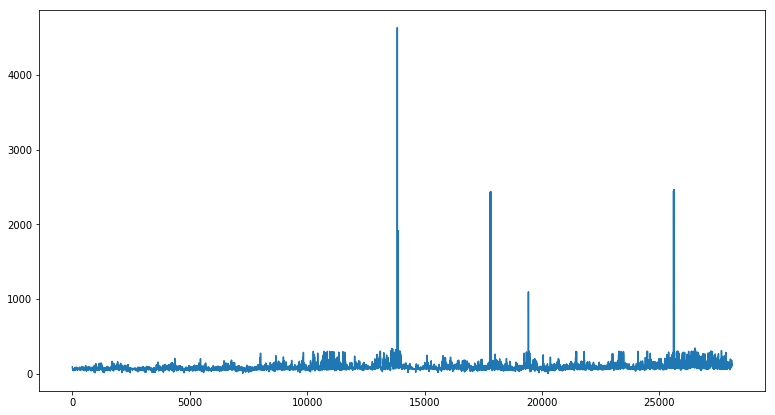

In [157]:
#Plot trend
Price = data["RRP"].values
plt.figure(figsize=(13,7))
plt.plot(Price)
plt.show()

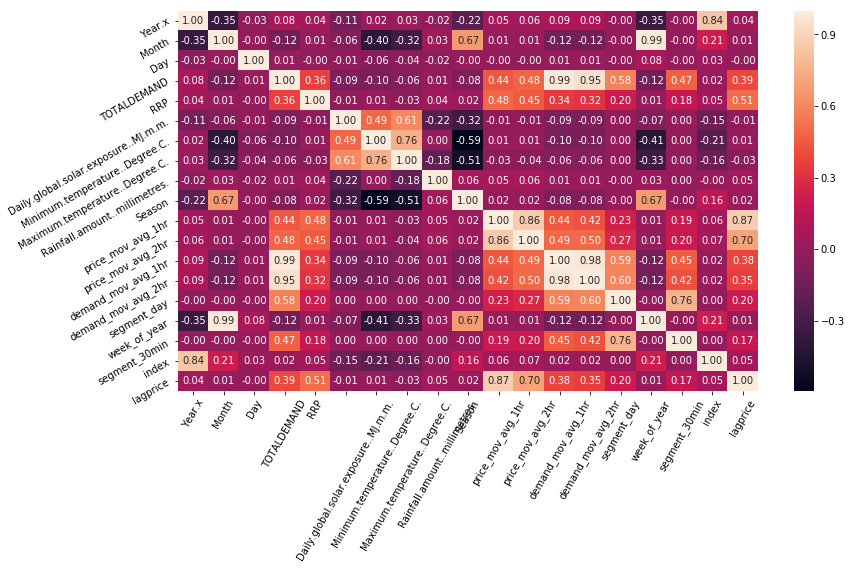

In [158]:
corr = data.corr()
plt.figure(figsize=(13,7))
a = sns.heatmap(corr, annot=True, fmt='.2f')
rotx = a.set_xticklabels(a.get_xticklabels(), rotation=60) 
roty = a.set_yticklabels(a.get_yticklabels(), rotation=30) 
plt.show()

# XG Boost

## Data Preparation

In [0]:
### ONE HOT-ENCONDING for TYPE OBJECTS 



In [0]:
#Drops Na  NON NA's
#data.dropna(axis=0, subset=['RRP'], inplace=True)

In [159]:
#Chek 
data.isnull().sum()

Year.x                                  0
Month                                   0
Day                                     0
TOTALDEMAND                             1
RRP                                     0
date_keep                               0
time_keep                               0
Daily.global.solar.exposure..MJ.m.m.    0
Minimum.temperature..Degree.C.          0
Maximum.temperature..Degree.C.          0
Rainfall.amount..millimetres.           0
Season                                  0
price_mov_avg_1hr                       2
price_mov_avg_2hr                       4
demand_mov_avg_1hr                      2
demand_mov_avg_2hr                      4
segment_day                             0
week_of_year                            0
day_of_week                             0
segment_30min                           0
index                                   0
lagprice                                1
dtype: int64

## Data Partitioning

In [0]:
# Objective variable selection
y = data.RRP
X = data.drop(['RRP', "date_keep", "time_keep", "index", "Year.x", "day_of_week"], axis=1)

In [0]:
#Prevous partitioning form
#train_X, test_X, train_y, test_y = train_test_split(X.as_matrix(), y.as_matrix(), test_size=0.30)

In [0]:
# Data partition
train_X = X[0:19656]
test_X = X[19656:28080]
train_y = y[0:19656]
test_y = y[19656:28080]


In [162]:
#Check data set partitioning 
train_X.shape, train_y.shape

((19656, 16), (19656,))

In [163]:
#Imputer FOR COMPLEATING MISSING VALUES 
my_imputer = Imputer()
train_X = my_imputer.fit_transform(train_X)
test_X = my_imputer.transform(test_X)




/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


## Model

In [166]:
# Build model
import xgboost
from xgboost import XGBRegressor

# Run The model
my_model = XGBRegressor()

# Train the model on training data
my_model.fit(train_X, train_y)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[05:03:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [0]:
# make predictions
predictions = my_model.predict(test_X)

In [168]:
#MAE
from sklearn.metrics import mean_absolute_error
print("Mean Absolute Error : " + str(mean_absolute_error(predictions, test_y)))

Mean Absolute Error : 18.842795065927824


In [169]:
#RMSE
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(predictions,test_y))
print("RMSE: " + str(rmse))

RMSE: 57.94665227289646


In [170]:
# Calculate the RMSE based on formula definition  LIKE IN RF
np.sqrt(((predictions - test_y) ** 2).mean()) 

57.94665227289643

In [171]:
# Lets calculate the accuracy of the model

# Calculate the absolute errors
errors = abs(predictions - test_y)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

  
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_y)

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.') #accuracy is 77.03%

Mean Absolute Error: 18.84 degrees.
Accuracy: 82.96 %.


## Hyper Parameter Tunning

### 1


In [184]:
# Early Stoppig Round And Learning rate
XGB_model = XGBRegressor(n_estimators=1000, learning_rate=0.05)
XGB_model.fit(train_X, train_y, early_stopping_rounds=50, 
             eval_set=[(test_X, test_y)], verbose=False)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[05:18:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [0]:
# make predictions
XGB_prediction = XGB_model.predict(test_X)



In [188]:
XGB_mse = mean_squared_error(XGB_predictions,test_y)
print("Mean Squared Error : " + str( np.sqrt(XGB_mse)))

Mean Squared Error : 52.86469876597505


In [189]:
# Lets calculate the accuracy of the model

# Calculate the absolute errors
XGB_errors = abs(XGB_predictions - test_y)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(XGB_errors), 2), 'degrees.')

  
# Calculate mean absolute percentage error (MAPE)
XGB_mape = 100 * (XGB_errors / test_y)

# Calculate and display accuracy
XGB_accuracy = 100 - np.mean(XGB_mape)
print('Accuracy:', round(XGB_accuracy, 2), '%.') #accuracy is 77.03%

Mean Absolute Error: 16.29 degrees.
Accuracy: 85.27 %.


## Predictions vs Actual Plot

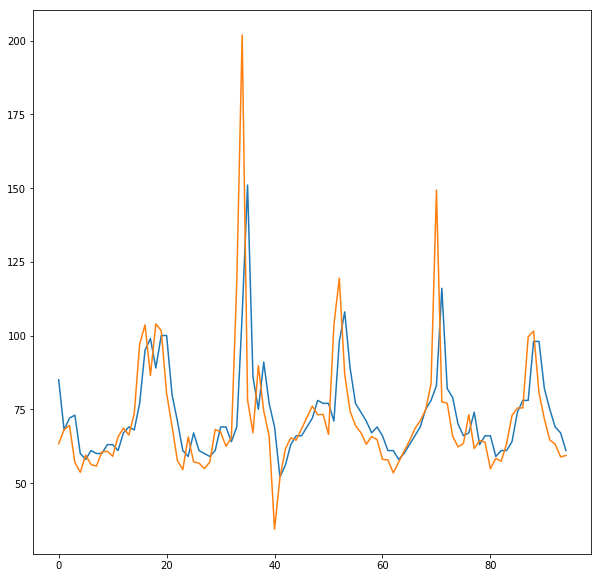

In [195]:
pred_sub = XGB_predictions[1:96]
testy_sub = np.array(test_y[1:96])

#yTest_sub
#pred_sub
plt.plot(pred_sub)
plt.plot(testy_sub)
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()

### 2. With Cross Validation

In [177]:
# Optimized Data Structure
data_dmatrix = xgboost.DMatrix(data=X,label=y)  ##DOES NOT HANDLE OBJECT

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [178]:
xgreg = xgboost.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 3, alpha = 10, n_estimators = 10000)

xgreg.fit(train_X, train_y, early_stopping_rounds=50, 
             eval_set=[(test_X, test_y)], verbose=False)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[05:10:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=10000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [0]:
xgreg_predictions = xg_reg.predict(test_X)

In [180]:
xgreg_rmse = np.sqrt(mean_squared_error(test_y, xgreg_predictions))
print("RMSE: %f" % (xgreg_rmse))

RMSE: 52.254304


In [181]:
# Lets calculate the accuracy of the model

# Calculate the absolute errors
xgreg_errors = abs(xgreg_predictions - test_y)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(xgreg_errors), 2), 'degrees.')

  
# Calculate mean absolute percentage error (MAPE)
xgreg_mape = 100 * (xgreg_errors / test_y)

# Calculate and display accuracy
xgreg_accuracy = 100 - np.mean(xgreg_mape)
print('Accuracy:', round(xgreg_accuracy, 2), '%.') #accuracy is 77.03%

Mean Absolute Error: 16.86 degrees.
Accuracy: 85.53 %.


#### k-fold Cross Validation

In [0]:
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.05, 'early_stopping_rounds':50,
                'max_depth': 3, 'alpha': 10}

In [0]:
cv_results = xgboost.cv(dtrain=data_dmatrix, params=params, nfold=10,
                    num_boost_round=100,early_stopping_rounds=50,metrics="rmse", as_pandas=True, seed=123)

[04:47:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:47:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:47:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:47:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:47:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:47:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:47:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:47:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [0]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,98.345002,1.536402,97.662944,12.931403
1,94.794072,1.601526,94.169079,13.263547
2,91.437399,1.664891,90.852470,13.546954
3,88.234338,1.694773,87.704221,13.898519
4,85.209795,1.720800,84.694689,14.138841


In [0]:
print((cv_results["test-rmse-mean"]).tail(1))

99    48.601906
Name: test-rmse-mean, dtype: float64


### Results Visualization

In [0]:
#????????? it only prints the naemes if I use this
xgreg = xgboost.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

[04:50:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


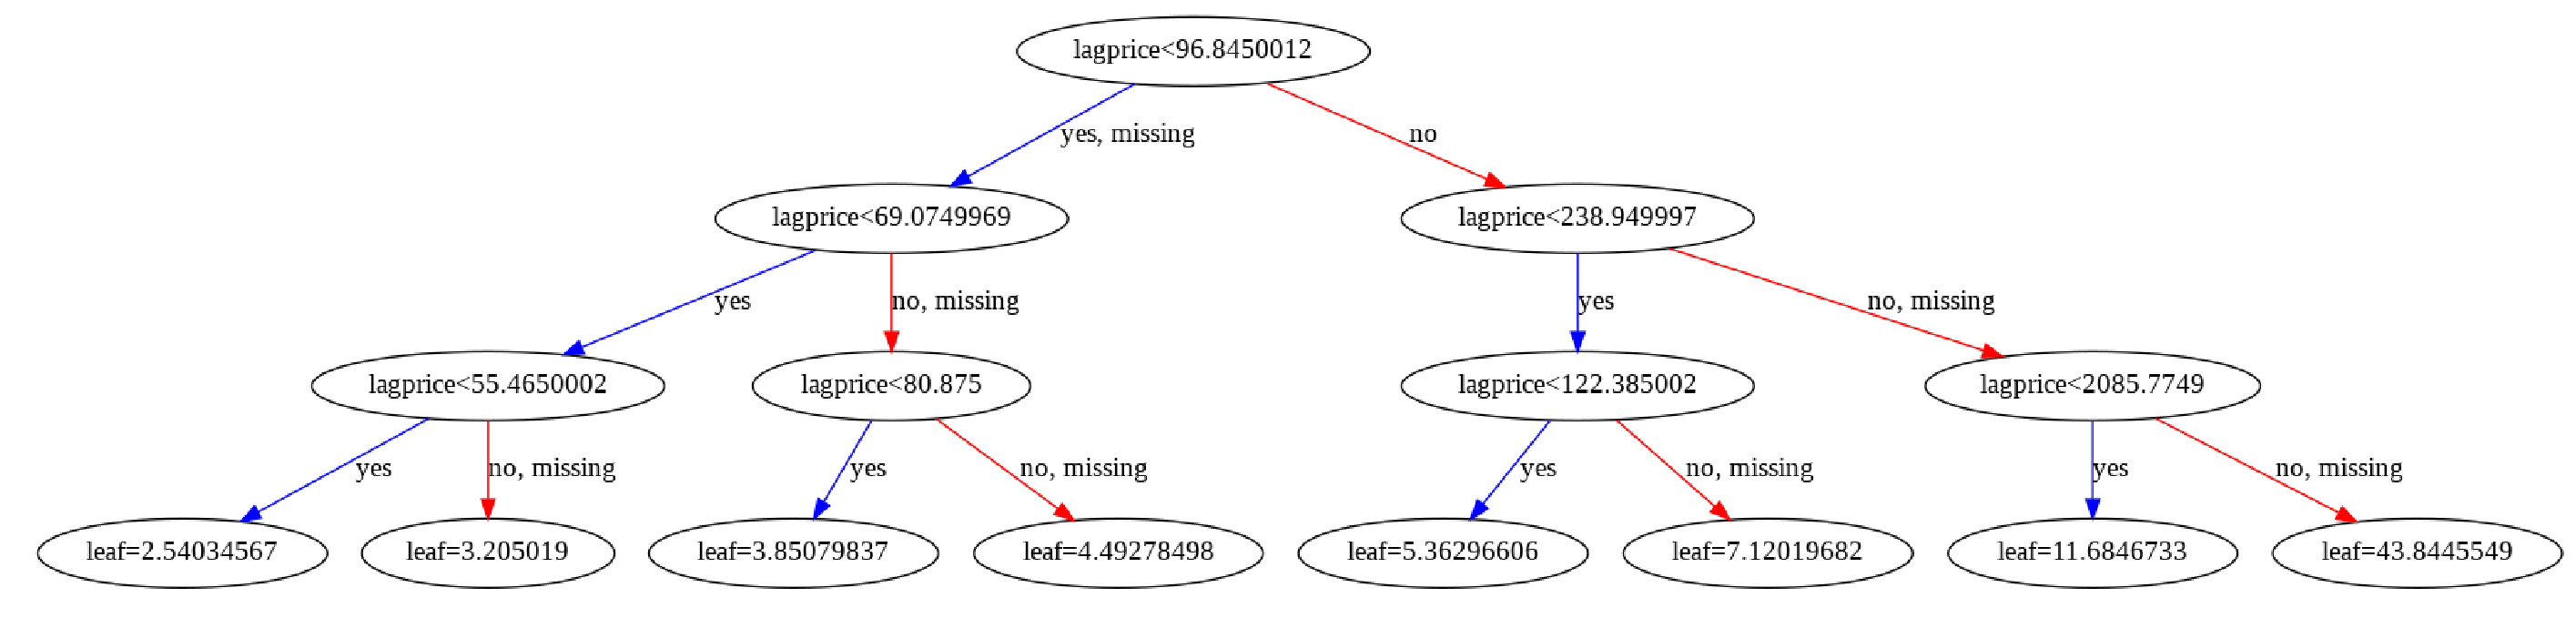

In [0]:
#Plot tree
xgboost.plot_tree(xgreg,num_trees=0)
plt.rcParams['figure.figsize'] = [50, 20]
plt.show()

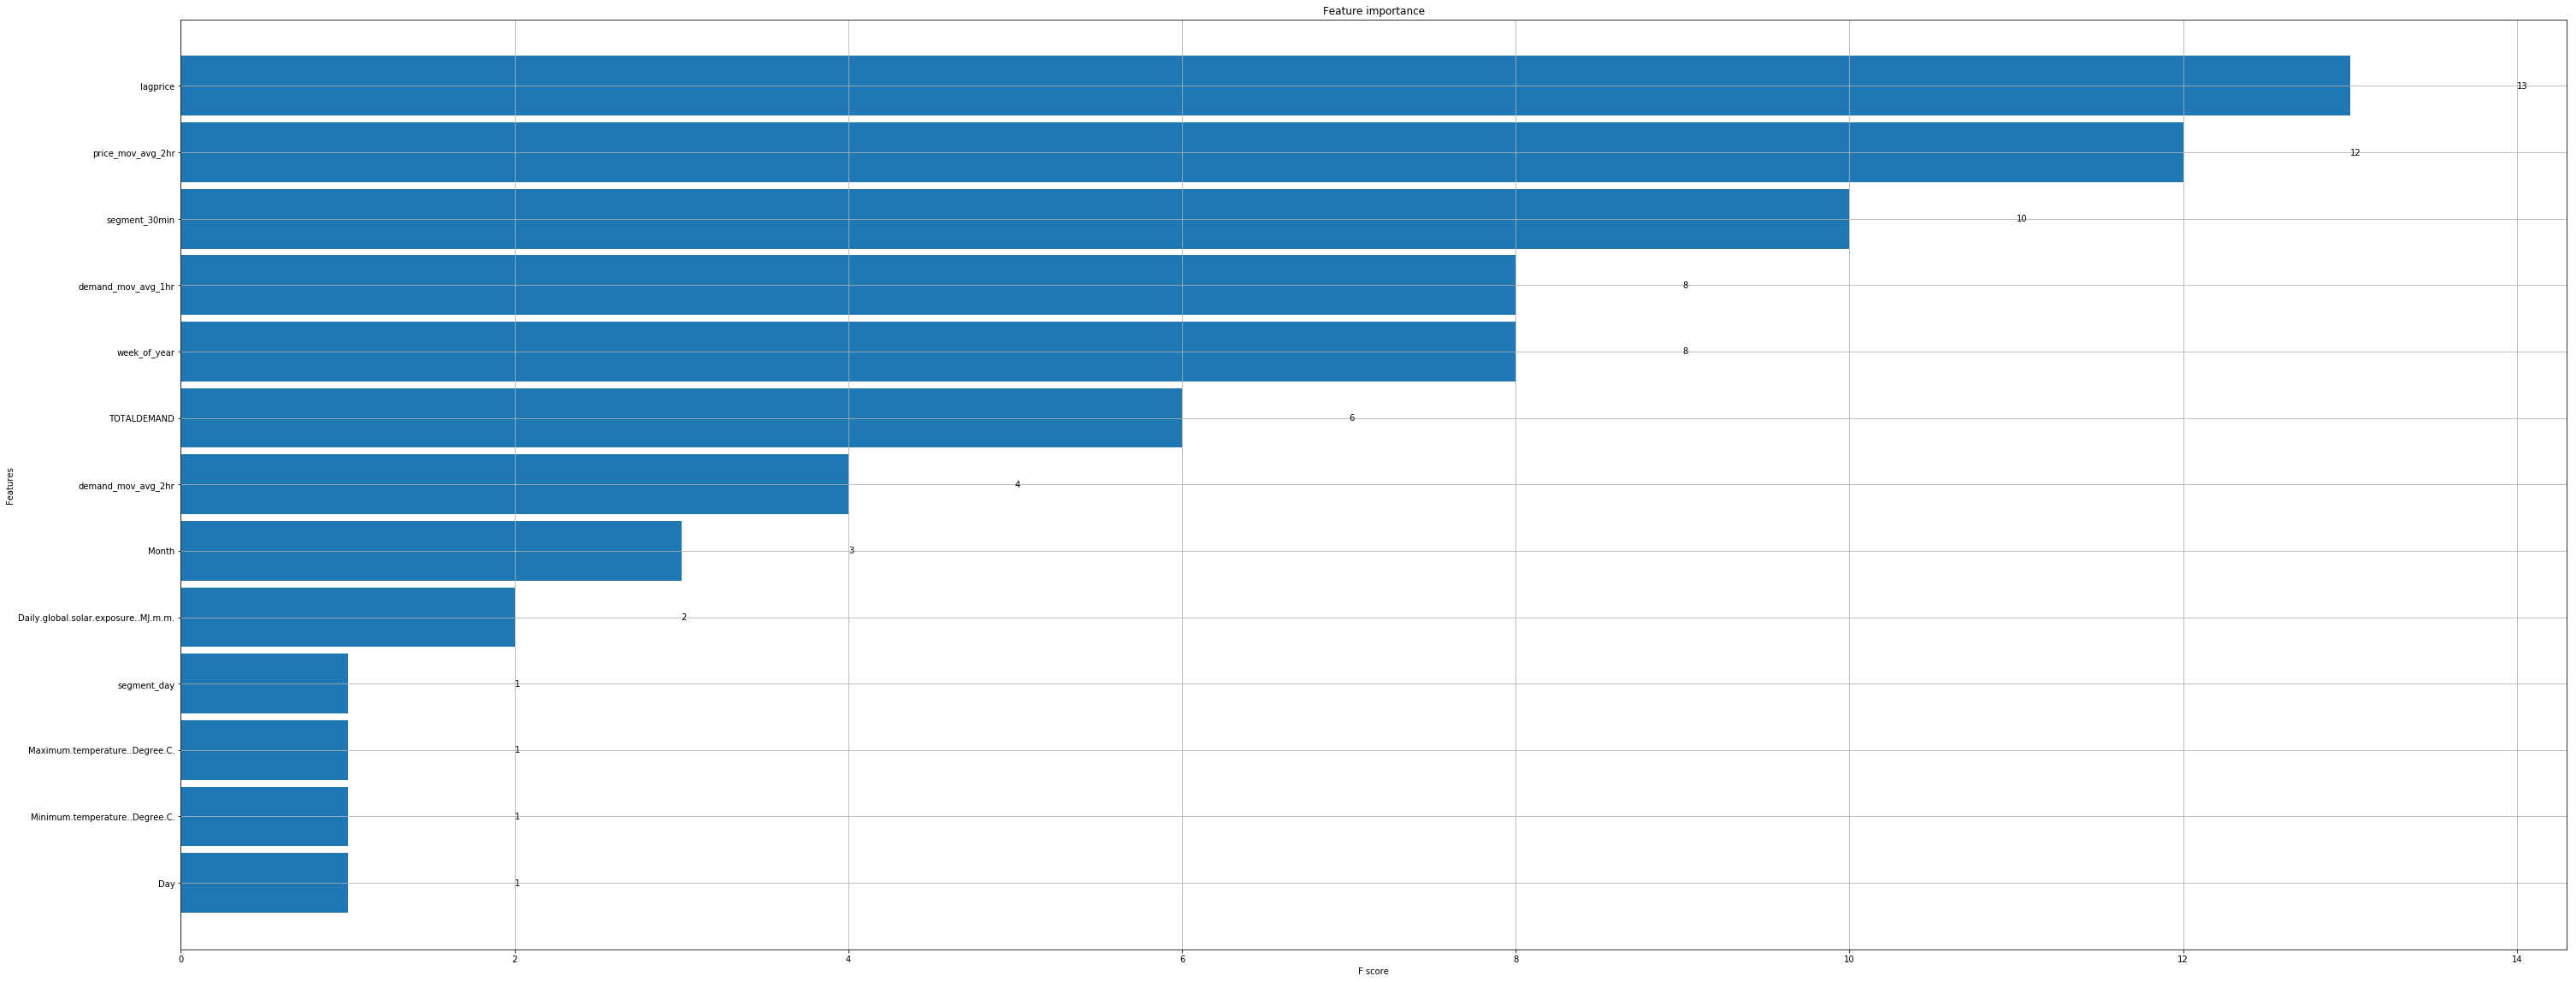

In [0]:
xgboost.plot_importance(xgreg, height=0.9)

In [0]:
##### FOR DECISION TREE

# Change Data Structure #XGB CAN ONLY MANAGE NUMERIC VARIABLES 

data.segment_30min = data.segment_30min.astype('category')

data.day_of_week = data.day_of_week.astype('category')

data.week_of_year = data.week_of_year.astype('category')

data.segment_day = data.segment_day.astype('category')

data.Season = data.Season.astype('category')

data.info()